In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Union, Any
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Load Data

In [3]:
batch_size = 32
seed = 2022

In [4]:
train_ds = tf.keras.utils.text_dataset_from_directory("data/train", batch_size=batch_size, seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory("data/val", batch_size=batch_size, seed=seed)
test_ds = tf.keras.utils.text_dataset_from_directory("data/test", batch_size=batch_size, seed=seed)

Found 112000 files belonging to 14 classes.


2022-04-21 00:02:47.950446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 00:02:47.969815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 00:02:47.969932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 00:02:47.970646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 14000 files belonging to 14 classes.
Found 14000 files belonging to 14 classes.


In [5]:
class_mappings = {num:lbl for num, lbl in enumerate(train_ds.class_names)}
class_mappings

{0: 'Assembly',
 1: 'C',
 2: 'C#',
 3: 'C++',
 4: 'GO',
 5: 'Java',
 6: 'JavaScript',
 7: 'Julia',
 8: 'Lua',
 9: 'Python',
 10: 'Ruby',
 11: 'Rust',
 12: 'SQL',
 13: 'Visual Basic'}

In [6]:
for txt, lbl in train_ds.take(1):
    for i in range(2):
        print(txt.numpy()[i])
        print(lbl.numpy()[i], class_mappings[lbl.numpy()[i]])
        print()

b'\xef\xbb\xbf\' Licensed to the .NET Foundation under one or more agreements.\n\' The .NET Foundation licenses this file to you under the MIT license.\n\' See the LICENSE file in the project root for more information.\n\nImports System.Runtime.CompilerServices\nImports Microsoft.CodeAnalysis\nImports Microsoft.CodeAnalysis.Test.Extensions\nImports Microsoft.CodeAnalysis.Test.Utilities\nImports Microsoft.CodeAnalysis.Text\nImports Microsoft.CodeAnalysis.VisualBasic\nImports Microsoft.CodeAnalysis.VisualBasic.Symbols\nImports Microsoft.CodeAnalysis.VisualBasic.Syntax\nImports Roslyn.Test.Utilities\n\nNamespace Microsoft.CodeAnalysis.VisualBasic.UnitTests.Symbols\n\n    Partial Public Class InstantiatingGenerics\n\n        <Fact>\n        Public Sub UnboundGenericType1()\n\n            Dim compilation = CompilationUtils.CreateCompilationWithMscorlib40AndVBRuntime(\n<compilation name="C">\n    <file name="a.vb">\nInterface I1\nEnd Interface\n\nClass C1\n    Class C2(Of T1, T2)\n        Im

In [7]:
VOCAB_SIZE = 20_000
vectorize_layer = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='binary', ngrams=1)

In [8]:
train_text = train_ds.map(lambda text, labels: text)

# vectorize_layer.adapt(train_text)
with tf.device("CPU"):
    vectorize_layer.adapt(train_text)

In [9]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [10]:
len(vectorize_layer.get_vocabulary())

20000

In [11]:
multi_train_ds = train_ds.map(vectorize_text)
multi_val_ds = val_ds.map(vectorize_text)
multi_test_ds = test_ds.map(vectorize_text)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
multi_train_ds = configure_dataset(multi_train_ds)
multi_val_ds = configure_dataset(multi_val_ds)
multi_test_ds = configure_dataset(multi_test_ds)

In [14]:
for txt, lbl in multi_train_ds.take(1):
    for i in range(2):
        print(txt.numpy()[i])
        print(lbl.numpy()[i], class_mappings[lbl.numpy()[i]])
        print()

[1. 1. 1. ... 0. 0. 0.]
13 Visual Basic

[1. 1. 0. ... 0. 0. 0.]
1 C



2022-04-21 00:03:32.096594: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
for txt, lbl in train_ds.take(1):
    for i in range(2):
        print(txt.numpy()[i])
        print(lbl.numpy()[i], class_mappings[lbl.numpy()[i]])
        print()

b'version https://git-lfs.github.com/spec/v1\noid sha256:b519d8c53881da3ce32f92a5c9f583c67d563ea9d7c5cacd3bf2503726443654\nsize 3420\n'
6 JavaScript

b'# Author: Jeremy Werner\n\n# Start in the same directory as kNN.jl\ninclude("kNN.jl")\n\nusing RDatasets\n\niris = dataset("datasets", "iris")\n\n\n# PetalLength and PetalWidth will be used for 2D example\nx_all = hcat(iris[:PetalLength], iris[:PetalWidth])\n\nsubset_n = 120\nx_train = x_all[1:subset_n, 1:2]\nx_test = x_all[(subset_n + 1):150, 1:2]\ny_in = array(iris[:Species][1:subset_n])\n\nreal_y = array(iris[:Species][(subset_n+1):(size(iris)[1])])\nn1 = length(real_y)\n\n# Fitting for k=2,6\ntest_predictions_2 = kNN(x_train, y_in, 2, x_test)\ntest_predictions_6 = kNN(x_train, y_in, 6, x_test)\n\n# Classification rates\nclass_2 = sum(real_y .== test_predictions_2) / n1\nclass_6 = sum(real_y .== test_predictions_6) / n1\n\n\n# Higher dimensional test\n\nx_all = hcat(iris[:PetalLength], iris[:PetalWidth], iris[:SepalLength], iris[:Sep

## Create Model

In [16]:
model = tf.keras.Sequential([
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

In [17]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
history = model.fit(multi_train_ds, validation_data=multi_val_ds, epochs=4)

Epoch 1/4
   1/3500 [..............................] - ETA: 45:09 - loss: 2.6465 - accuracy: 0.0625

2022-04-21 00:03:33.149385: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3500/3500 [==============================] - 29s 8ms/step - loss: 0.4208 - accuracy: 0.9376 - val_loss: 0.1900 - val_accuracy: 0.9598
Epoch 2/4
3500/3500 [==============================] - 4s 1ms/step - loss: 0.1328 - accuracy: 0.9674 - val_loss: 0.1433 - val_accuracy: 0.9624
Epoch 3/4
3500/3500 [==============================] - 4s 1ms/step - loss: 0.0926 - accuracy: 0.9752 - val_loss: 0.1296 - val_accuracy: 0.9641
Epoch 4/4
3500/3500 [==============================] - 4s 1ms/step - loss: 0.0730 - accuracy: 0.9797 - val_loss: 0.1284 - val_accuracy: 0.9644


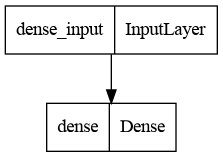

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
model.evaluate(multi_test_ds)

438/438 [==============================] - 3s 7ms/step - loss: 0.1381 - accuracy: 0.9596


[0.1380937546491623, 0.9595714211463928]

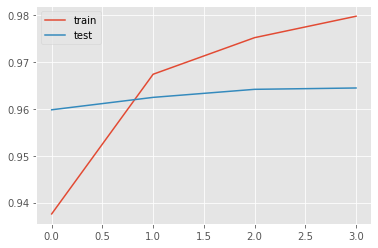

In [21]:
plt.style.use('ggplot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

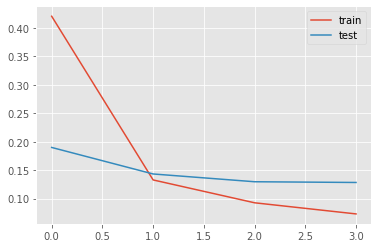

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
exported_model = tf.keras.Sequential([
    vectorize_layer,
    model,
])

In [24]:
exported_model.compile(loss=losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'],
)

In [25]:
exported_model.evaluate(test_ds)


438/438 [==============================] - 4s 8ms/step - loss: 0.1381 - accuracy: 0.9596


[0.1380937546491623, 0.9595714211463928]

In [26]:
exported_model.predict(['#include <string>']).argmax()

3

In [27]:
exported_model.predict(['import os; os.system("ls -l")']).argmax()

9

In [28]:
class_mappings[exported_model.predict(
    [
        """
#include <iostream>
#include <string>
#include <vector>


int main()
{
    std::string s = "  prepress  ";
    int n = 3;
    std::vector<std::string> v;

    // create n-grams using the string s of size n, and store them in v
    for (int i = 0; i < s.size() - n + 1; i++)
    {
        v.push_back(s.substr(i, n));
    }

    // print the n-grams vector
    for (int i = 0; i < v.size(); i++)
    {
        std::cout << v[i] << std::endl;
    }

    return 0;
}
        """
    ]
).argmax()]


'C++'

In [29]:
# inputs = tf.keras.Input(shape=(1,), dtype="string")
# processed_inputs = vectorize_layer(inputs)
# outputs = model(processed_inputs)
# inference_model = tf.keras.Model(inputs, outputs)

# raw_text_data = tf.convert_to_tensor([
# ['import os; os.system("ls -l")'],
# ])

# inference_model(raw_text_data)

In [30]:
# save the model
model_name = "code_classifier"
exported_model.save(f'models/{model_name}', save_format='tf')

2022-04-21 00:04:21.662676: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/code_classifier/assets


In [31]:
loaded_model = tf.keras.models.load_model(f'models/{model_name}')

In [32]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20000)            0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 14)                280014    
                                                                 
Total params: 280,014
Trainable params: 280,014
Non-trainable params: 0
_________________________________________________________________


In [33]:
loaded_model.predict(['#include <string>']).argmax()

3

In [34]:
class_mappings[loaded_model.predict(['#include <string>']).argmax()]

'C++'